# Feed-forward network

## Imports


In [2]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
from IPython import display

## Helper functions

In [108]:
def decision_boundary(fn) -> tuple[list, list, list]:
    x = np.linspace(-1, 1, 100)
    y = np.linspace(-1, 1, 100)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros(X.shape)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i, j] = fn([X[i, j], Y[i, j]])

    return X, Y, Z


def generate_linear(n: int, shift: int = 0.3) -> tuple[npt.ArrayLike, npt.ArrayLike]:
    X = np.random.uniform(-1, 1, (100, 2))
    y = np.zeros(100)
    y[X[:, 0] + X[:, 1] + shift > 0] = 1
    return X, y


def generate_circle(n: int, r: float = 0.8) -> tuple[npt.ArrayLike, npt.ArrayLike]:
    X = np.random.uniform(-1, 1, (100, 2))
    y = np.zeros(100)
    y[X[:, 0] ** 2 + X[:, 1] ** 2 < r**2] = 1
    return X, y


def generate_ring(n: int, inner_r: float = 0.5, outer_r: float = 0.8) -> tuple[npt.ArrayLike, npt.ArrayLike]:
    X = np.random.uniform(-1, 1, (100, 2))
    y = np.zeros(100)
    y[(X[:, 0] ** 2 + X[:, 1] ** 2 > outer_r**2) | (X[:, 0] ** 2 + X[:, 1] ** 2 < inner_r**2)] = 1
    return X, y

## Network implementation

In [60]:
# Activation functions


class Sigmoid:
    @staticmethod
    def f(x: npt.ArrayLike) -> npt.ArrayLike:
        return 1 / (1 + np.exp(-x))

    @staticmethod
    def df(x: npt.ArrayLike) -> npt.ArrayLike:
        a = Sigmoid.f(x)
        return a * (1 - a)


class Tanh:
    @staticmethod
    def f(x: npt.ArrayLike) -> npt.ArrayLike:
        return np.tanh(x)

    @staticmethod
    def df(x: npt.ArrayLike) -> npt.ArrayLike:
        a = Tanh.f(x)
        return 1 - a * a


class ReLU:
    @staticmethod
    def f(x: npt.ArrayLike) -> npt.ArrayLike:
        return np.maximum(0, x)

    @staticmethod
    def df(x: npt.ArrayLike) -> npt.ArrayLike:
        return (x > 0).astype(int)

In [61]:
# Loss functions


class MeanSquaredError:
    @staticmethod
    def f(y_pred: npt.ArrayLike, y_true: npt.ArrayLike) -> npt.ArrayLike:
        return np.mean((y_true - y_pred) ** 2)

    @staticmethod
    def df(y_pred: npt.ArrayLike, y_true: npt.ArrayLike) -> npt.ArrayLike:
        return y_pred - y_true

In [62]:
# Initializers


class XavierUniform:
    @staticmethod
    def f(x: int, y: int) -> npt.ArrayLike:
        return np.random.uniform(-1, 1, (x, y)) * np.sqrt(6 / (x + y))


class Zeros:
    @staticmethod
    def f(x: int, y: int) -> npt.ArrayLike:
        return np.zeros((x, y))

In [66]:
class Layer:
    def __init__(
        self,
        in_size: int,
        out_size: int,
        activation=Tanh,
        init_weights=XavierUniform,
        init_biases=Zeros,
    ):
        self.activation = activation

        # Initialise weights and biases to random values
        # self.weights = np.random.rand(out_size, in_size)
        # self.biases = np.random.rand(1, out_size)[0]
        self.weights = init_weights.f(out_size, in_size)
        self.biases = init_biases.f(1, out_size)[0]

        self.grad_weights = np.zeros(self.weights.shape)
        self.grad_biases = np.zeros(self.biases.shape)

    def __repr__(self):
        in_size = self.weights.shape[1]
        out_size = self.weights.shape[0]
        return f"Layer(in={in_size}, out={out_size}, activation={self.activation.__name__})"

    def forward(self, inputs: npt.ArrayLike, training: bool = False) -> npt.ArrayLike:
        # Calculate the weighted sum of inputs and add the bias
        z = np.dot(self.weights, inputs) + self.biases

        # Store inputs and weighted inputs for backpropagation
        if training:
            self.inputs = inputs
            self.z = z

        # Apply the activation function
        return self.activation.f(z)

    def update_grads(self, dinputs: npt.ArrayLike) -> npt.ArrayLike:
        # Calculate the gradient of the loss with respect to the weighted sum
        d_z = dinputs * self.activation.df(self.z)
        self.grad_weights += np.dot(d_z[:, None], self.inputs[None, :])
        self.grad_biases += d_z
        return d_z

    def apply_grads(self, lr: float) -> None:
        # Update weights and biases
        self.weights -= lr * self.grad_weights
        self.biases -= lr * self.grad_biases

        # Reset gradients
        self.grad_weights = np.zeros(self.weights.shape)
        self.grad_biases = np.zeros(self.biases.shape)

        # Reset inputs and weighted inputs
        self.inputs = None
        self.z = None


class Network:
    def __init__(self, layers: list[Layer], lr: float = 0.01, loss=MeanSquaredError):
        self.layers = layers
        self.learning_rate = lr
        self.loss = loss

    def __repr__(self):
        return f"Network({self.layers}, lr={self.learning_rate}, loss={self.loss.__name__})"

    def forward(self, inputs: npt.ArrayLike, training: bool = False) -> npt.ArrayLike:
        for layer in self.layers:
            inputs = layer.forward(inputs, training)

        return inputs

    def train(self, input_data: npt.ArrayLike, target_data: npt.ArrayLike) -> float:
        loss = 0
        for inputs, targets in zip(input_data, target_data):
            loss += self.update_grads(inputs, targets)

        for layer in self.layers:
            layer.apply_grads(self.learning_rate)

        return loss / len(input_data)

    def update_grads(self, inputs: npt.ArrayLike, targets: npt.ArrayLike) -> float:
        # Forward pass
        predictions = self.forward(inputs, training=True)

        # Backward pass
        dinputs = self.loss.df(predictions, targets)
        for layer in reversed(self.layers):
            d_z = layer.update_grads(dinputs)
            dinputs = np.dot(layer.weights.T, d_z)

        return self.loss.f(predictions, targets)

## Automatic training

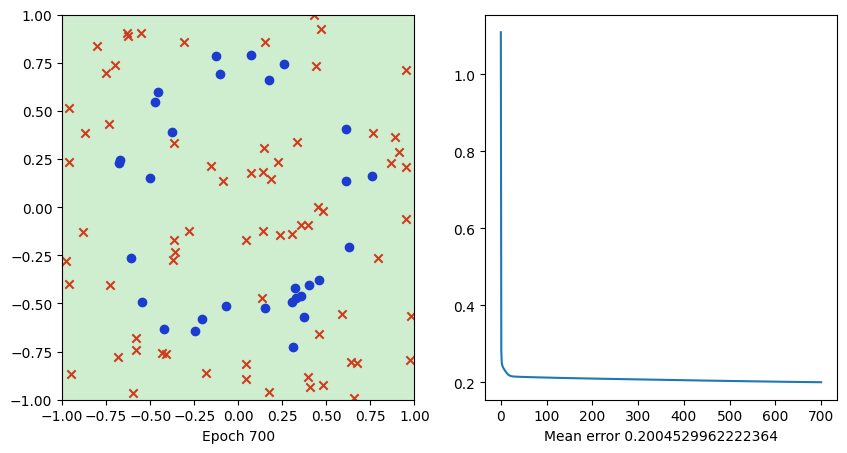

In [113]:
np.random.seed(0)
net = Network([Layer(2, 3), Layer(3, 3), Layer(3, 1)], lr=0.0025, loss=MeanSquaredError)
# X, y = generate_linear(100, shift=0.3)
# X, y = generate_circle(100, r=0.8)
X, y = generate_ring(100, inner_r=0.5, outer_r=0.8)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))


errors = []
for i in range(1001):
    err = net.train(X, y)
    errors.append(err)

    if i % 10 != 0:
        continue

    Xd, Yd, Zd = decision_boundary(lambda x: net.forward(x)[0] > 0.5)

    ax1.clear()
    ax1.scatter(X[y == 0, 0], X[y == 0, 1], c="blue", marker="o")
    ax1.scatter(X[y == 1, 0], X[y == 1, 1], c="red", marker="x")
    ax1.contourf(Xd, Yd, Zd, levels=[-1, 0, 1], alpha=0.3)

    ax2.clear()
    ax2.plot(errors)

    ax1.set_xlabel(f"Epoch {i}")
    ax2.set_xlabel(f"Mean error {err}")

    display.clear_output(wait=True)
    display.display(fig)

    if err == 0:
        break

display.clear_output(wait=True)